In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import os 

from ast import literal_eval

In [2]:
data = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train.csv")
target = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
print(f"DATA SHAPE : {data.shape}")
data.head()

DATA SHAPE : (30083, 13)


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


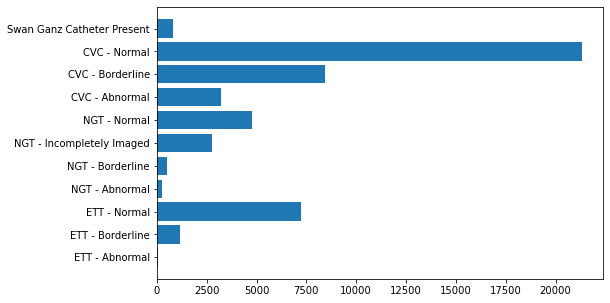

In [3]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.barh(target,data.iloc[:,1:12].sum())
plt.show()
#クラスがかなり偏っていることがわかる 

In [4]:
print(f'Number of Unique Patients : {np.unique(data["PatientID"].values).shape[0]}')
#同じ患者さんが含まれているのでValidationの仕方に気をつける

Number of Unique Patients : 3255


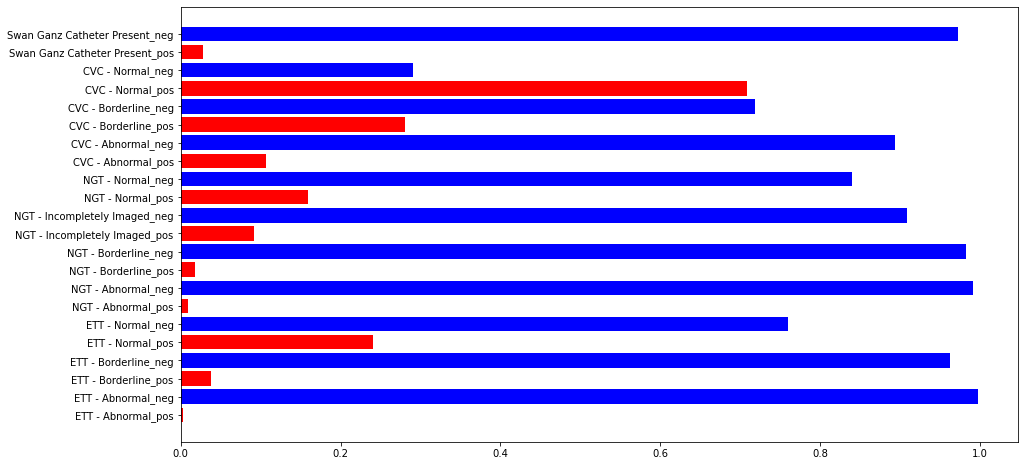

In [5]:
def compute_class_label_freqs(labels):
    labels = np.array(labels)
    positive = np.sum(labels,axis=0)/len(labels)
    negative = 1 - positive 
    return positive,negative

pos,neg = compute_class_label_freqs(data.loc[:,target])
fig,ax = plt.subplots(1,1,figsize=(15,8))

for i,t in enumerate(target):
    ax.barh(f"{t}_pos",pos[i],color = "red")
    ax.barh(f"{t}_neg",neg[i],color = "blue")
plt.show()

#クラスが全く均衡じゃない

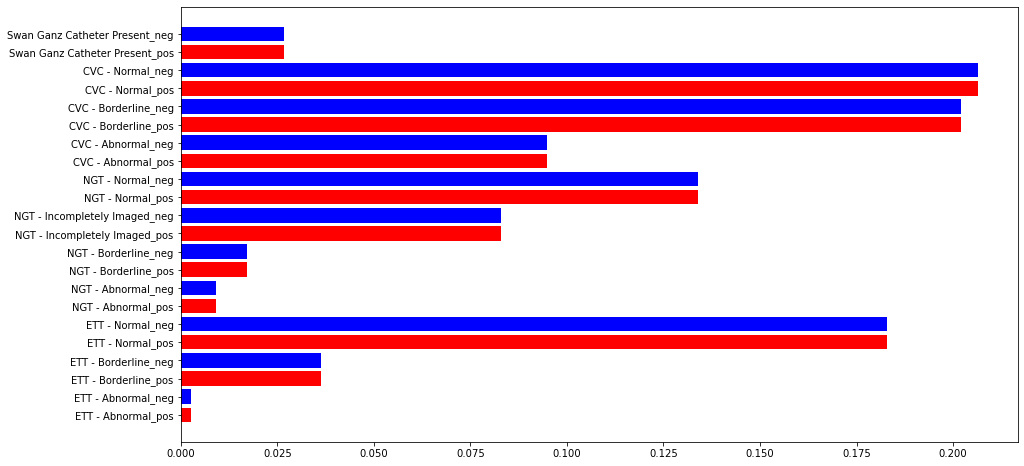

In [6]:
#データにweightをつけて学習させる
pos_weight = neg 
neg_weight = pos 

weighted_pos = pos * pos_weight
weighted_neg = neg * neg_weight

fig,ax = plt.subplots(1,1,figsize=(15,8))
for i,t in enumerate(target):
    ax.barh(f"{t}_pos",weighted_pos[i],color = "red")
    ax.barh(f"{t}_neg",weighted_neg[i],color = "blue")
plt.show()


## Images

In [7]:
annotations = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train_annotations.csv")
annotations["data"] = annotations["data"].apply(literal_eval)
print(f"ANNOTATION COUNT: {annotations.shape[0]}")
#リストを連結したような文字列が入っているのでlistに変える

ANNOTATION COUNT: 17999


In [8]:
imageIds = {}
for t in target:
    imageIds[t] = data[data[t] == 1]['StudyInstanceUID'].to_list()

In [9]:
def plot_image_and_annotations(image_uid,title,singleLabel=True):
    image_path = "../input/ranzcr-clip-catheter-line-classification/train/" + image_uid + ".jpg"
    data = annotations[annotations["StudyInstanceUID"] == image_uid]
    if singleLabel :
        data = data[data["label"] == title]
    data = data["data"]
    if len(data) == 0:
        print(title)
        return 
    
    img = plt.imread(image_path) 
    print(title)
    print(f"Image dimensions:  {img.shape[0],img.shape[1]}")
    print(f"Maximum pixel value : {img.max():.1f} ; Minimum pixel value:{img.min():.1f}")
    print(f"Mean value of the pixels : {img.mean():.1f} ; Standard deviation : {img.std():.1f}")
    
    fig,axes = plt.subplots(1,2,figsize=(10,6))
    
    # Actual
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Actual Image')
    axes[0].axis('off')
    
    # Annotated
    axes[1].imshow(img, cmap='gray')
    axes[1].set_title("Annotated Image")
    axes[1].axis('off')
    x_loc = np.array(data.values[0])[:,0]
    y_loc = np.array(data.values[0])[:,1]    
    axes[1].scatter(x_loc, y_loc, linewidth = 5.0)
    
    plt.tight_layout()
    plt.show()

ETT - Abnormal
Image dimensions:  (2500, 2048)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 151.1 ; Standard deviation : 56.0


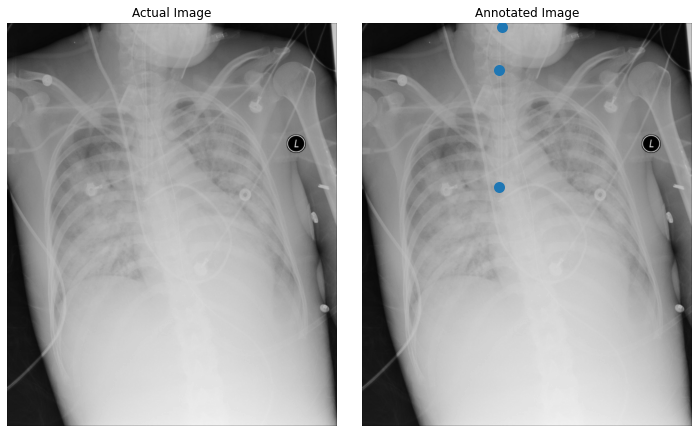

In [10]:
plot_image_and_annotations(imageIds[target[0]][0], target[0])

In [11]:
plot_image_and_annotations(imageIds[target[1]][0], target[1])
#必ずannotationがついているわけではない

ETT - Borderline


ETT - Normal
Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 120.5 ; Standard deviation : 72.2


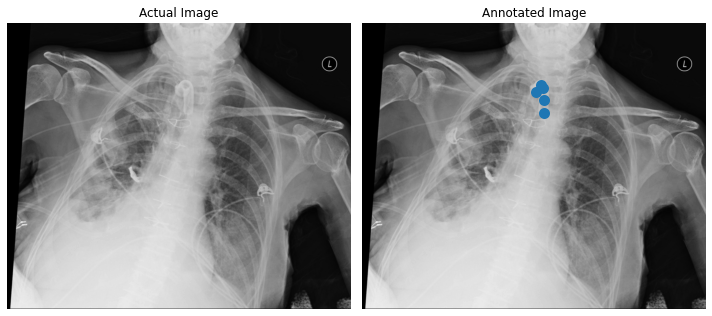

In [12]:
plot_image_and_annotations(imageIds[target[2]][-1], target[2])

NGT - Abnormal
Image dimensions:  (2048, 2500)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 113.0 ; Standard deviation : 55.6


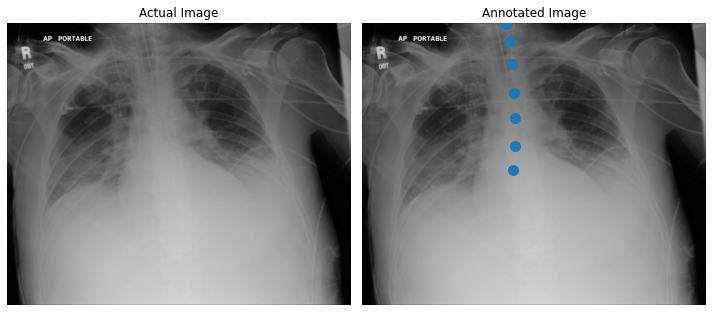

In [13]:
plot_image_and_annotations(imageIds[target[3]][-1], target[3])

NGT - Borderline
Image dimensions:  (2991, 2992)
Maximum pixel value : 250.0 ; Minimum pixel value:0.0
Mean value of the pixels : 133.5 ; Standard deviation : 65.5


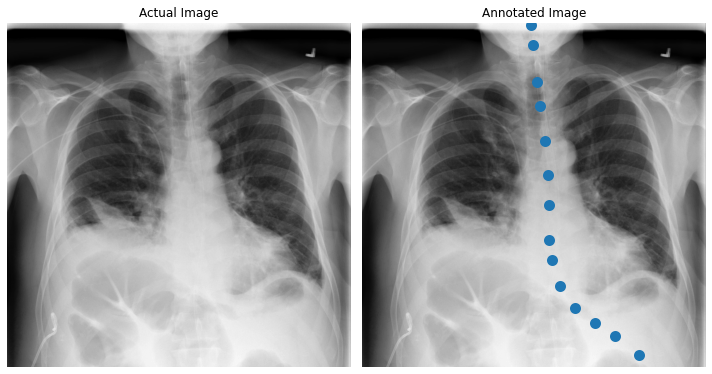

In [14]:
plot_image_and_annotations(imageIds[target[4]][-1], target[4])

NGT - Incompletely Imaged
Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 116.3 ; Standard deviation : 67.4


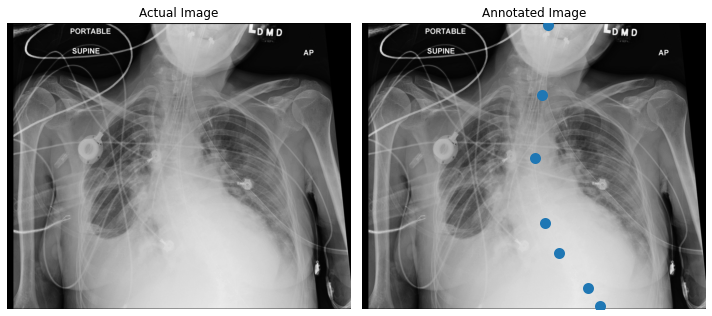

In [15]:
plot_image_and_annotations(imageIds[target[5]][-1], target[5])

NGT - Normal
Image dimensions:  (2048, 2500)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 114.8 ; Standard deviation : 51.2


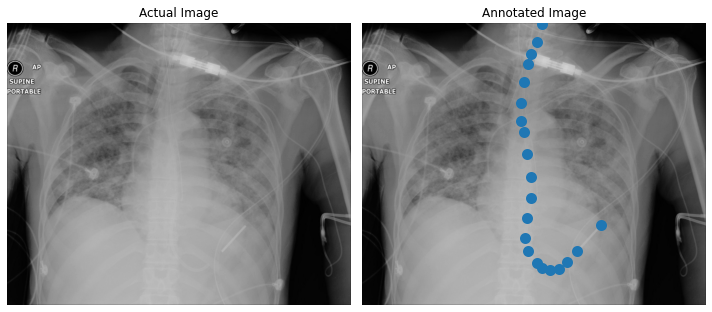

In [16]:
plot_image_and_annotations(imageIds[target[6]][4], target[6])

CVC - Abnormal
Image dimensions:  (2048, 2500)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 157.9 ; Standard deviation : 50.1


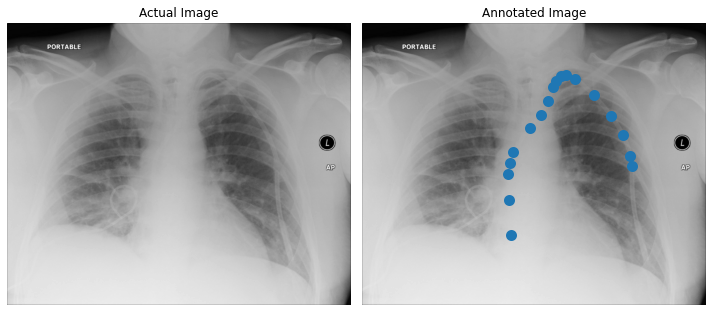

In [17]:
plot_image_and_annotations(imageIds[target[7]][4], target[7])

CVC - Borderline
Image dimensions:  (2048, 2500)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 119.6 ; Standard deviation : 47.1


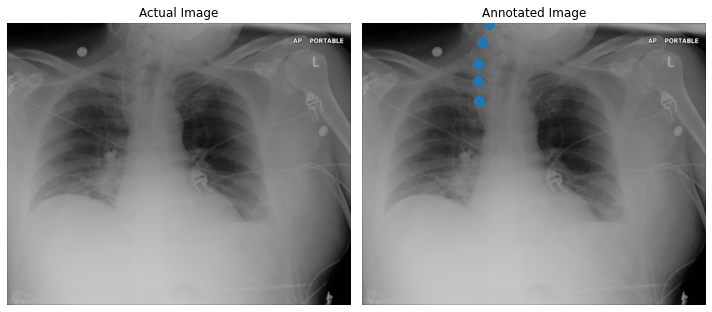

In [18]:
plot_image_and_annotations(imageIds[target[8]][4], target[8])

CVC - Normal
Image dimensions:  (2544, 3056)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 120.5 ; Standard deviation : 72.2


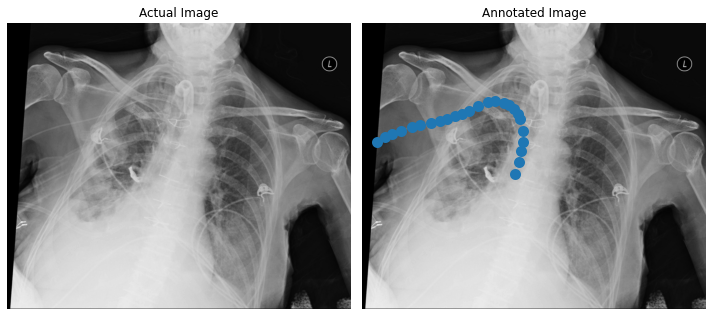

In [19]:
plot_image_and_annotations(imageIds[target[9]][-1], target[9])

Swan Ganz Catheter Present
Image dimensions:  (2500, 2048)
Maximum pixel value : 229.0 ; Minimum pixel value:0.0
Mean value of the pixels : 108.5 ; Standard deviation : 61.9


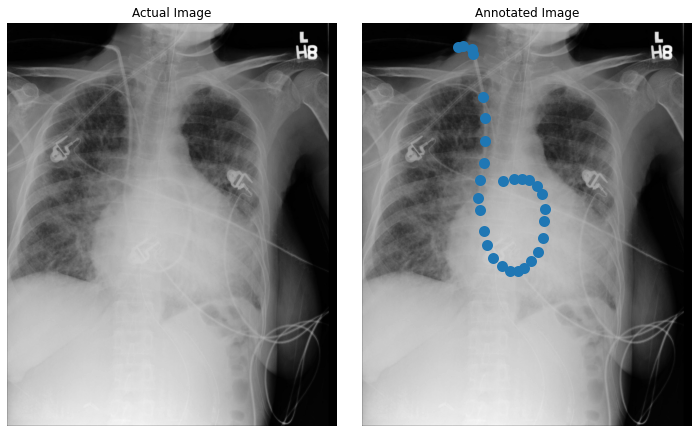

In [20]:
plot_image_and_annotations(imageIds[target[10]][-2], target[10])